# Bayes Classifier
#### In this Notebook we will have a look at bayes classifiers.
#### We will label data in Roboflow, load the labeled data here and then train a classifier with sci-kit learn and write our own classifier. 

### Approaches:
We will train different classifiers. We will create our own classifier from scratch and then compare it to the sci-kit learn classifier: 
- One will be a pixel-by pixel classifier. Which in the end basically just takes the color value as an input (we will need a gaussian filter for preprocessing) and then classifies according to pixel color. 
- The other approach is to have polygons applied to the test data and classify according to the shape. Then classify the whole area at once (averaged) instead of each pixel independently

I am interested in two things here: How will be the potato be classified in the two approaches (which is not as a class in the train set) and how much worse will a pixel-by pixel classifier be than the shape one (Assuming the shape classifier will be close to perfect). 

### Datasets: 
We will work on two datasets: 
- *Fruit Dataset*:\
This will be the first and primary dataset. The dataset contains 3 classes (and the background which is arguably a 4th class)

- *Melanoma Dataset*:\
We will use the melanoma segmentation from an earlier assignment as training data to classify melanomas

In [1]:
import os
import cv2
import numpy as np
import seaborn as sns
from glob import glob
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split


In [2]:
def extract_polygon_features(image, polygon_points):
    """
    Create a mask for the polygon and compute the average BGR color within it.
    """
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [polygon_points], 255)
    mean_val = cv2.mean(image, mask=mask)[:3] #avg BGR colro extraction
    return np.array(mean_val)

def parse_annotation_line(line, image_width, image_height):
    """
    Parse one line of the annotation file.
    
    Expected format:
      <class> x1 y1 x2 y2 ... xn yn
      
    The coordinates are normalized. This function converts them to pixel coordinates.
    Returns the class label (as int) and a NumPy array of polygon points.
    """
    tokens = line.strip().split()
    if len(tokens) < 3:
        return None, None
    try:
        cls = int(tokens[0])
    except ValueError:
        return None, None
    # The remaining tokens are the polygon points in normalized coordinates.
    num_points = (len(tokens) - 1) // 2
    points = []
    for i in range(num_points):
        try:
            x_norm = float(tokens[1 + 2*i])
            y_norm = float(tokens[1 + 2*i + 1])
        except ValueError:
            continue
        x_pixel = int(x_norm * image_width)
        y_pixel = int(y_norm * image_height)
        points.append([x_pixel, y_pixel])
    if len(points) < 3:
        # Not a valid polygon.
        return None, None
    points = np.array(points, dtype=np.int32)
    return cls, points


## Training whole polygon classifier: 
Here we train the classifier for whole polygons (averaged BGR values). THis should lead to almost perfect results.(except the potato ;P )

In [3]:

train_image_dir = './train/images'
train_label_dir = './train/labels'

# class names deleted by roboflow (-> instead numbers -> need to "reapply names")
class_map = {0: 'banana', 1: 'chily', 2: 'egg'}

# Lists to store feature vectors and corresponding labels.
X_train = []
y_train = []

# Iterate through all images in the training directory.
for image_path in glob(os.path.join(train_image_dir, '*')): # all img in train dir
    img = cv2.imread(image_path)
    h, w = img.shape[:2]
    base = os.path.splitext(os.path.basename(image_path))[0]
    label_path = os.path.join(train_label_dir, base + '.txt') # roboflow puts weird extensions to the files, but at least they are the same  in labels and img lol
    with open(label_path, 'r') as f:
        lines = f.read().strip().splitlines()
    for line in lines:
        cls, poly_points = parse_annotation_line(line, w, h)
        feature = extract_polygon_features(img, poly_points)
        X_train.append(feature)
        y_train.append(cls)

X_train = np.array(X_train)
y_train = np.array(y_train)

print("Number of training samples:", X_train.shape[0])

# Train the Gaussian Naive Bayes classifier.
clf = GaussianNB()
clf.fit(X_train, y_train)

Number of training samples: 32


GaussianNB()

## Let's check how well it works and what our potato is doing 

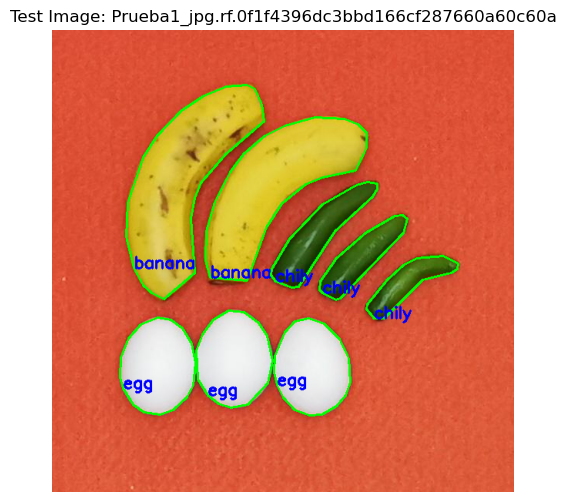

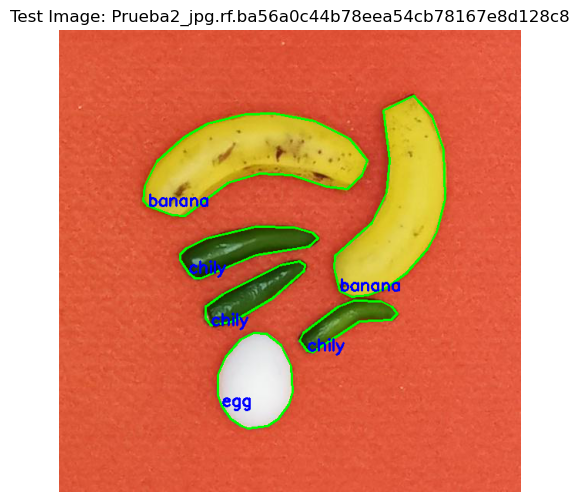

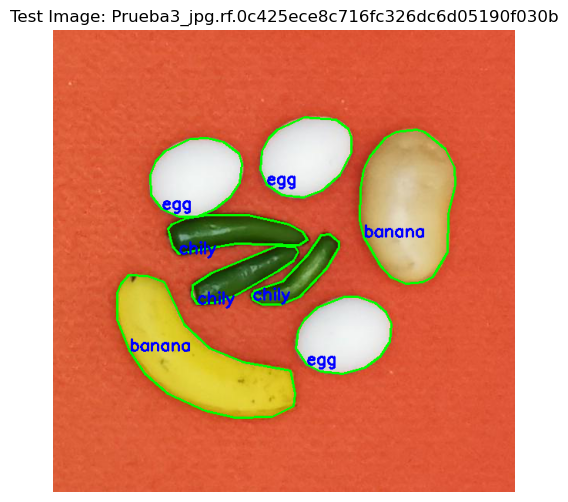

In [ ]:
test_image_dir = './test/images'
test_label_dir = './test/labels'

# Iterate over all tests images
for image_path in glob(os.path.join(test_image_dir, '*')):
    img = cv2.imread(image_path)

    img_draw = img.copy()
    h, w = img.shape[:2]
    base = os.path.splitext(os.path.basename(image_path))[0]
    label_path = os.path.join(test_label_dir, base + '.txt')
    with open(label_path, 'r') as f:
        lines = f.read().strip().splitlines()
    for line in lines:
        cls, poly_points = parse_annotation_line(line, w, h)

        # Extract feature and predict the class.
        feature = extract_polygon_features(img, poly_points).reshape(1, -1)
        pred = clf.predict(feature)[0]
        label_text = class_map.get(pred, str(pred))


        # Draw the polygon (green outline) and put predicted class text (red) near the first point. 
        cv2.polylines(img_draw, [poly_points], isClosed=True, color=(0, 255, 0), thickness=2)
        cv2.putText(img_draw, label_text, tuple(poly_points[0]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

    #plotting everything togetheer 
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB))
    plt.title(f"Test Image: {base}")
    plt.axis('off')
    plt.show()


___
# Pixel-by-Pixel approach
Now let's try the other approach where we don't have the masks for objects in the test data.\
We will train a classifier based on the pxel RGB value and. To get rid of noise and average the colors we will preprocess the imgs with a gaussian filter. 

First we need to mask the image and we need to create a new background class. (which we didn't need earlier as we were only passing the area which is to classify)


In [5]:
def create_mask_from_annotation(image_shape, annotation_path, background_class):
    """
    Create a mask from a polygon annotation file.
    Each line should have:
      <class> x1 y1 x2 y2 ... xn yn
    with normalized coordinates.
    The function converts these into pixel coordinates and fills the polygon
    with the given class label. Any pixel not covered by a polygon is later
    assigned to the background_class.
    """
    mask = np.full((image_shape[0], image_shape[1]), -1, dtype=np.int32)
    with open(annotation_path, 'r') as f:
        lines = f.read().strip().splitlines()
    for line in lines:
        tokens = line.strip().split()

        cls = int(tokens[0])
        coords = []
        h, w = image_shape[:2]
        # Parse each pair of coordinates.
        for i in range(1, len(tokens), 2):
            x_norm = float(tokens[i])
            y_norm = float(tokens[i+1])
            x = int(x_norm * w)
            y = int(y_norm * h)
            coords.append([x, y])
        if len(coords) >= 3:
            pts = np.array(coords, dtype=np.int32)
            cv2.fillPoly(mask, [pts], cls)

    # Assign any pixel not covered by an annotation to background. -> If not everything goes bananas (literally haha)
    mask[mask == -1] = background_class
    return mask


# Let's train the sci-kit learn classifier
As the color areas are pretty different we can go hardcore on the bluring but need to pay attention that we don't loose the edges on the foods

Number of training samples (pixels): 1440000


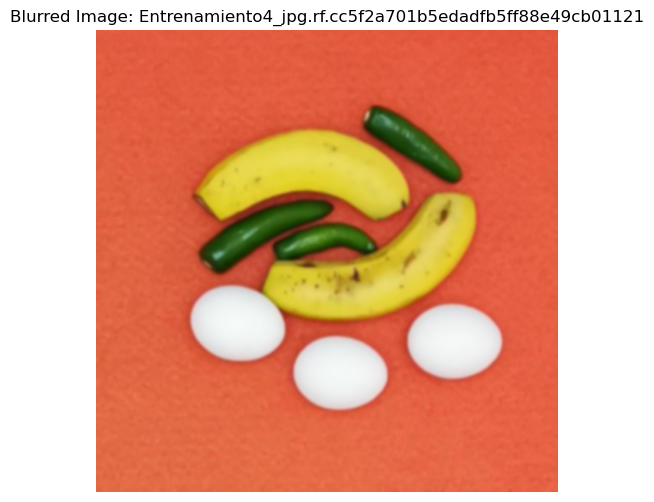

In [6]:
background_class = 3

gaussian_kernel_size = (9, 9) # Played around with this a lot -> tradeoff edge to noise
gaussian_sigma = 0          # -> THis is pretty cool -> OpenCv automatically calculates the sigma based on the kernel size if set to 0

X_train = []
y_train = []


train_image_paths = glob(os.path.join(train_image_dir, '*'))
for image_path in train_image_paths:
    img = cv2.imread(image_path)
    
    # Applythe gaussian
    img_blur = cv2.GaussianBlur(img, gaussian_kernel_size, gaussian_sigma)
    h, w = img.shape[:2]
    
    # Get the corresponding annotation file (assumes same base name with .txt).
    base = os.path.splitext(os.path.basename(image_path))[0]
    label_path = os.path.join(train_label_dir, base + '.txt')
    
    # Create a mask from annotations.
    mask = create_mask_from_annotation(img.shape, label_path, background_class)
    valid_indices = np.where(mask >= 0)
    pixels = img_blur[valid_indices].astype(np.float32)
    labels = mask[valid_indices]
    
    X_train.append(pixels)
    y_train.append(labels)

# Concatenate training samples from all images.
X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

print("Number of training samples (pixels):", X_train.shape[0])

# Train the Gaussian Naive Bayes classifier.
clf = GaussianNB()
clf.fit(X_train, y_train)


# plotting one of the blurred images
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(img_blur, cv2.COLOR_BGR2RGB))
plt.title(f"Blurred Image: {base}")
plt.axis('off')
plt.show()


# Now as this seemed to work, let's write our own classifier, before continuing to evaluate both
This was not as simple as first thought... 
Credits to (https://www.youtube.com/watch?v=TLInuAorxqE&ab_channel=AssemblyAI) 

In [ ]:
class MyGaussianNB:
    def __init__(self):
        self.classes_ = None
        self.means_ = {}               # Mean for each class
        self.covariances_ = {}         # Full cov mat for each class.
        self.inv_covariances_ = {}     
        self.log_det_covariances_ = {} # Log det of covariance mat to do the trick of addding instead of multiplying.
        self.priors_ = {}              
    
    def fit(self, X, y):
        """
        Fit the model using training data X (shape: [n_samples, n_features])
        and corresponding labels y.
        """
        self.classes_ = np.unique(y)
        total_samples = len(y)
        for c in self.classes_:
            X_c = X[y == c]
            # Compute the mean vector.
            self.means_[c] = np.mean(X_c, axis=0)
            # Compute the full covariance matrix using N (not N-1).
            cov = np.cov(X_c, rowvar=False, bias=True)
            # Add a small regularization term to the diagonal.
            cov += np.eye(cov.shape[0]) * 1e-9 # -> "numerical stability" -> I reaaaaaaally don't get why
            self.covariances_[c] = cov
            # Precompute the inverse and log determinant.
            self.inv_covariances_[c] = np.linalg.inv(cov)
            sign, logdet = np.linalg.slogdet(cov)
            self.log_det_covariances_[c] = logdet
            # Compute the prior probability.
            self.priors_[c] = X_c.shape[0] / total_samples
    
    def _log_likelihood(self, X, c):
        """
        Compute the log likelihood of each sample in X under the Gaussian model for class c.
        X is an array of shape (n_samples, n_features).
        """
        mean = self.means_[c]
        inv_cov = self.inv_covariances_[c]
        log_det = self.log_det_covariances_[c]
        d = X.shape[1]
        diff = X - mean  # Xi - müh
        # Compute quadratic form : S = (x - mu)^T S^-1 (x - mu) for each sample.
        quad_form = np.sum((diff @ inv_cov) * diff, axis=1) 
        # Return the log likelihood.
        return -0.5 * (d * np.log(2 * np.pi) + log_det + quad_form)
    
    def predict_proba(self, X):
        """
        Compute the posterior probability for each class for every sample in X.
        Returns an array of shape (n_samples, n_classes).
        """
        n_samples = X.shape[0]
        n_classes = len(self.classes_)
        log_probs = np.zeros((n_samples, n_classes))
        for idx, c in enumerate(self.classes_):
            log_prior = np.log(self.priors_[c])
            log_likelihood = self._log_likelihood(X, c)
            log_probs[:, idx] = log_prior + log_likelihood
        # Convert log probabilities to actual probabilities in a numerically stable way.
        max_log = np.max(log_probs, axis=1, keepdims=True)
        probs = np.exp(log_probs - max_log)
        probs /= np.sum(probs, axis=1, keepdims=True)
        return probs
    
    def predict(self, X):
        """
        Predict the class label for each sample in X.
        """
        probs = self.predict_proba(X)
        class_indices = np.argmax(probs, axis=1)
        classes = np.array(list(self.classes_))
        return classes[class_indices]

    

# Old version from tut. With this I had problems getting eval metrics 

    # def fit(self, X, y):
    #     n_samples, n_features = X.shape
    #     self._classes = np.unique(y)
    #     n_classes = len(self._classes)

    #     # calculate mean, var, and prior for each class
    #     self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
    #     self._var = np.zeros((n_classes, n_features), dtype=np.float64)
    #     self._priors = np.zeros(n_classes, dtype=np.float64)

    #     for idx, c in enumerate(self._classes):
    #         X_c = X[y == c]
    #         self._mean[idx, :] = X_c.mean(axis=0)
    #         self._var[idx, :] = X_c.var(axis=0)
    #         self._priors[idx] = X_c.shape[0] / float(n_samples)
            

    # def predict(self, X):
    #     y_pred = [self._predict(x) for x in X]
    #     return np.array(y_pred)

    # def _predict(self, x):
    #     posteriors = []

    #     # calculate posterior probability for each class
    #     for idx, c in enumerate(self._classes):
    #         prior = np.log(self._priors[idx])
    #         posterior = np.sum(np.log(self._pdf(idx, x)))
    #         posterior = posterior + prior
    #         posteriors.append(posterior)

    #     # return class with the highest posterior
    #     return self._classes[np.argmax(posteriors)]

    # # posterior density function
    # def _pdf(self, class_idx, x):
    #     mean = self._mean[class_idx]
    #     var = self._var[class_idx]
    #     numerator = np.exp(-((x - mean) ** 2) / (2 * var))
    #     denominator = np.sqrt(2 * np.pi * var)
    #     return numerator / denominator

    



custom_clf = MyGaussianNB()
custom_clf.fit(X_train, y_train)


# Let's see how the classifiers are doing

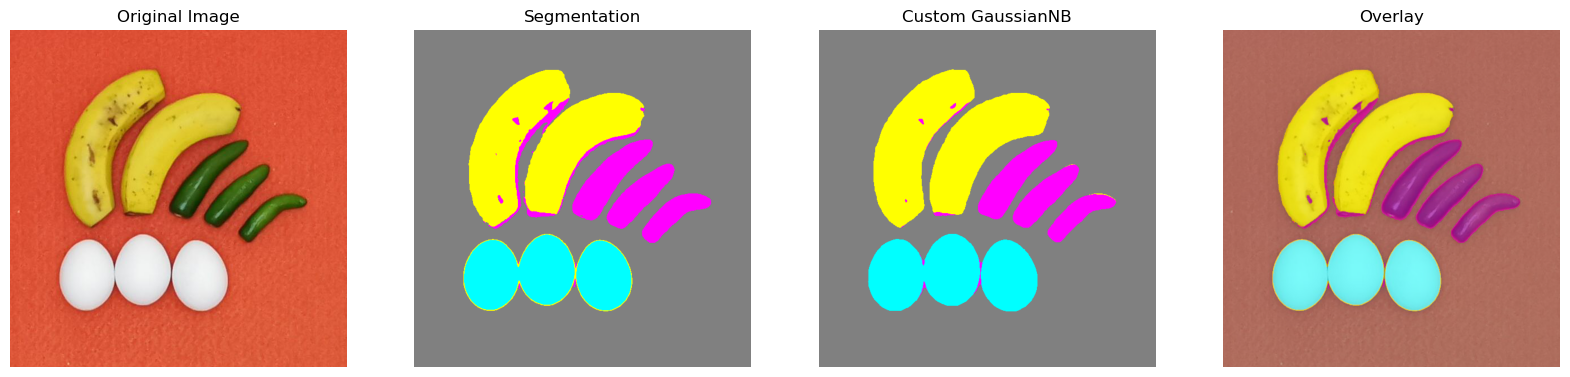

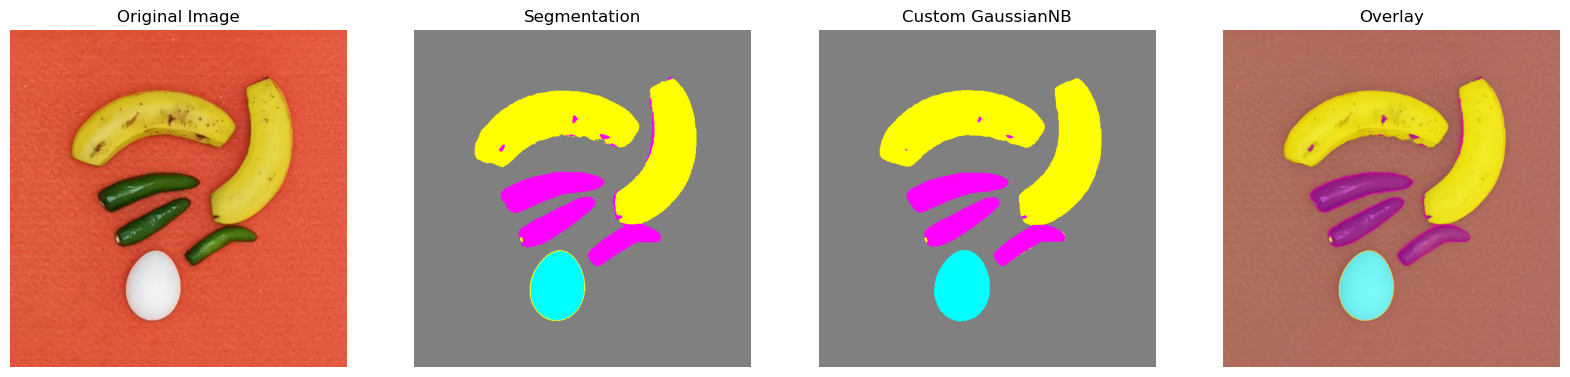

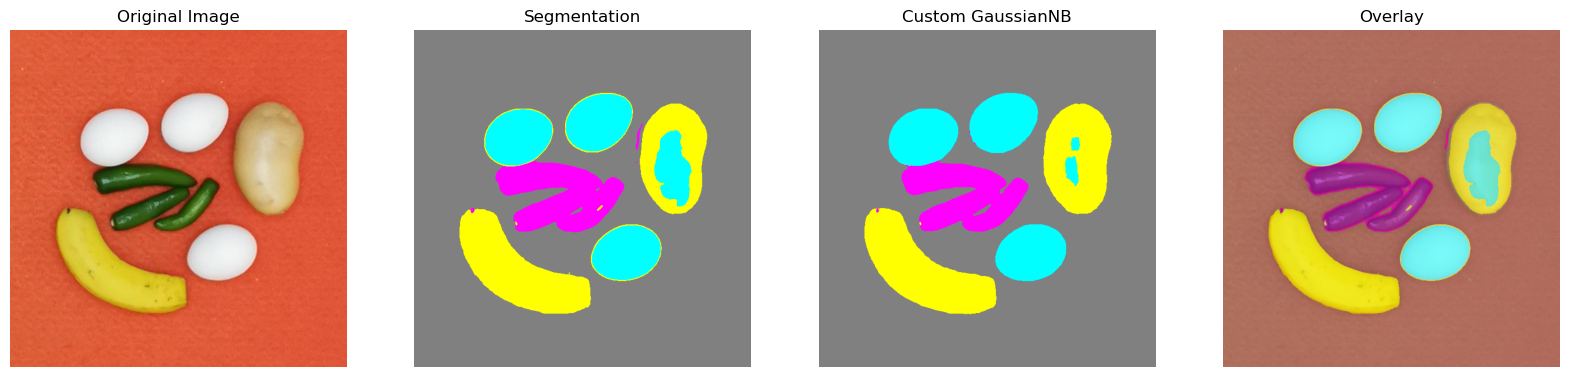

In [8]:
y_pred_sklearn_all = []
y_pred_custom_all = []

# color map for overlay plitting 
color_map = { 
    0: (0, 255, 255),  
    1: (255, 0, 255),  
    2: (255, 255, 0), 
    3: (128, 128, 128)
}

# Iterate over all test images.
test_image_paths = glob(os.path.join(test_image_dir, '*'))
for image_path in test_image_paths:
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Could not load test image {image_path}. Skipping.")
        continue
    
    # Apply the same Gaussian filter to the test image -> QUESTION: unsure if this is way to go???
    img_blur = cv2.GaussianBlur(img, gaussian_kernel_size, gaussian_sigma)
    h, w = img.shape[:2]
    
    # Reshape the image to a list of pixels (each with 3 features).
    pixels = img_blur.reshape(-1, 3).astype(np.float32) # -> better results with blur!
    # pixels = img.reshape(-1, 3).astype(np.float32) # -> more error prune in reflections
    preds = clf.predict(pixels)
    pred_mask = preds.reshape(h, w)

    # Eigener classifier preds
    preds_custom = custom_clf.predict(pixels)
    mask_custom = preds_custom.reshape(h, w)

    
    # segmentation image for visualization.
    seg_image = np.zeros_like(img)
    seg_custom = np.zeros_like(img)
    

    for cls, color in color_map.items():
        seg_image[pred_mask == cls] = color
        seg_custom[mask_custom == cls] = color
    
    # Overlay of the segs on orig img
    overlay = cv2.addWeighted(img, 0.5, seg_image, 0.5, 0)
    overlay_custom = cv2.addWeighted(img, 0.5, seg_custom, 0.5, 0)

    # Acc results
    y_pred_sklearn_all.extend(preds)
    y_pred_custom_all.extend(preds_custom)
    
    
    # Display the original image, segmentation, and overlay.
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(1, 4, 2)
    plt.imshow(cv2.cvtColor(seg_image, cv2.COLOR_BGR2RGB))
    plt.title("Segmentation")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(cv2.cvtColor(seg_custom, cv2.COLOR_BGR2RGB))
    plt.title("Custom GaussianNB")
    plt.axis("off")
    
    plt.subplot(1, 4, 4)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title("Overlay")
    plt.axis("off")
    
    plt.show()


# Numeric Evaluation
Now let's see how the classifiers are doing numerically.\
We will calculate the following values to do so: 
- Accuracy Score
- ROC-Curve
- Confusion Matrix

In [9]:
# We didn't calc probs so let's do that here
# init lists to eval the classifier performance.
y_true_all = []
y_prob_sklearn_all = []
y_prob_custom_all = []

test_image_paths = glob(os.path.join(test_image_dir, '*'))
for image_path in test_image_paths:
    base = os.path.splitext(os.path.basename(image_path))[0]
    label_path = os.path.join(test_label_dir, base + '.txt')

    img = cv2.imread(image_path)
    img_blur = cv2.GaussianBlur(img, gaussian_kernel_size, gaussian_sigma)
    h, w = img.shape[:2]
    
    # ground truth mask.
    gt_mask = create_mask_from_annotation(img.shape, label_path, background_class)
    
    # Reshape image pixels and ground truth mask to 1D arrays.
    pixels = img_blur.reshape(-1, 3).astype(np.float32)
    gt_pixels = gt_mask.reshape(-1)
    
    prob_sklearn = clf.predict_proba(pixels)
    prob_custom = custom_clf.predict_proba(pixels)

    # acc results.
    y_true_all.extend(gt_pixels)
    y_prob_sklearn_all.append(prob_sklearn)
    y_prob_custom_all.append(prob_custom)


y_true_all = np.array(y_true_all)
y_pred_sklearn_all = np.array(y_pred_sklearn_all)
y_pred_custom_all = np.array(y_pred_custom_all)
y_prob_sklearn_all = np.concatenate(y_prob_sklearn_all, axis=0)
y_prob_custom_all = np.concatenate(y_prob_custom_all, axis=0)




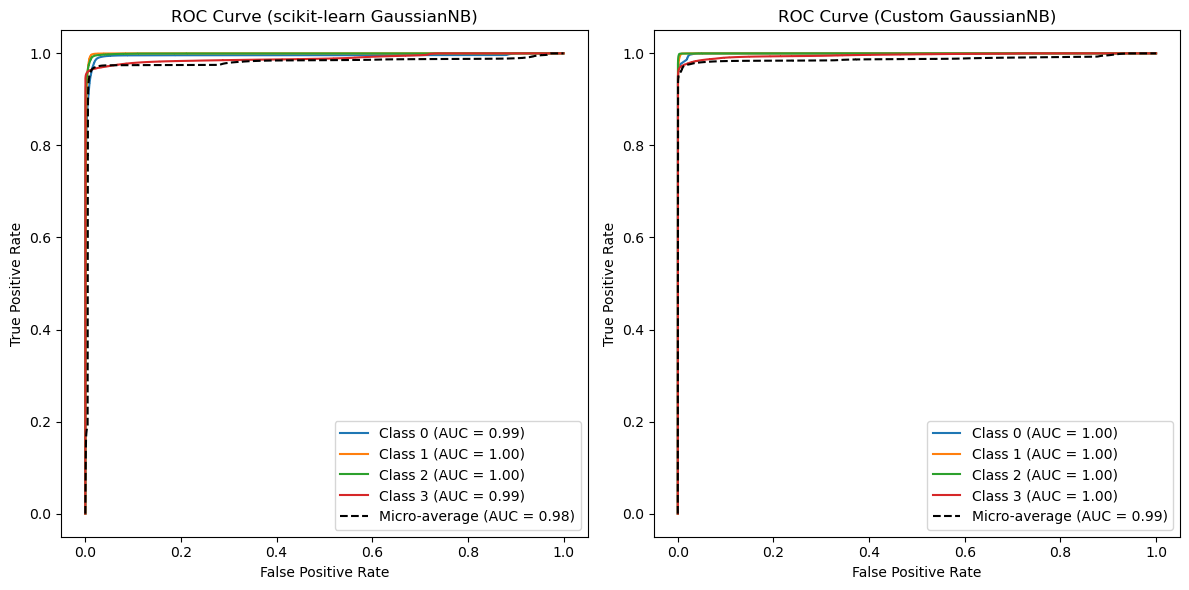

In [10]:
classes = [0, 1, 2, 3]
y_true_bin = label_binarize(y_true_all, classes=classes)
n_classes = y_true_bin.shape[1]

fpr_sklearn = {}
tpr_sklearn = {}
roc_auc_sklearn = {}
fpr_custom = {}
tpr_custom = {}
roc_auc_custom = {}

for i in range(n_classes):
    fpr_sklearn[i], tpr_sklearn[i], _ = roc_curve(y_true_bin[:, i], y_prob_sklearn_all[:, i])
    roc_auc_sklearn[i] = auc(fpr_sklearn[i], tpr_sklearn[i])
    
    fpr_custom[i], tpr_custom[i], _ = roc_curve(y_true_bin[:, i], y_prob_custom_all[:, i])
    roc_auc_custom[i] = auc(fpr_custom[i], tpr_custom[i])

# Compute micro-average ROC curve and AUC.
fpr_sklearn["micro"], tpr_sklearn["micro"], _ = roc_curve(y_true_bin.ravel(), y_prob_sklearn_all.ravel())
roc_auc_sklearn["micro"] = auc(fpr_sklearn["micro"], tpr_sklearn["micro"])

fpr_custom["micro"], tpr_custom["micro"], _ = roc_curve(y_true_bin.ravel(), y_prob_custom_all.ravel())
roc_auc_custom["micro"] = auc(fpr_custom["micro"], tpr_custom["micro"])

# Plot the ROC curves for both classifiers.
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for i in range(n_classes):
    plt.plot(fpr_sklearn[i], tpr_sklearn[i],
             label=f"Class {classes[i]} (AUC = {roc_auc_sklearn[i]:.2f})")
plt.plot(fpr_sklearn["micro"], tpr_sklearn["micro"],
         linestyle="--", color="black",
         label=f"Micro-average (AUC = {roc_auc_sklearn['micro']:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (scikit-learn GaussianNB)")
plt.legend()

plt.subplot(1, 2, 2)
for i in range(n_classes):
    plt.plot(fpr_custom[i], tpr_custom[i],
             label=f"Class {classes[i]} (AUC = {roc_auc_custom[i]:.2f})")
plt.plot(fpr_custom["micro"], tpr_custom["micro"],
         linestyle="--", color="black",
         label=f"Micro-average (AUC = {roc_auc_custom['micro']:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Custom GaussianNB)")
plt.legend()

plt.tight_layout()
plt.show()

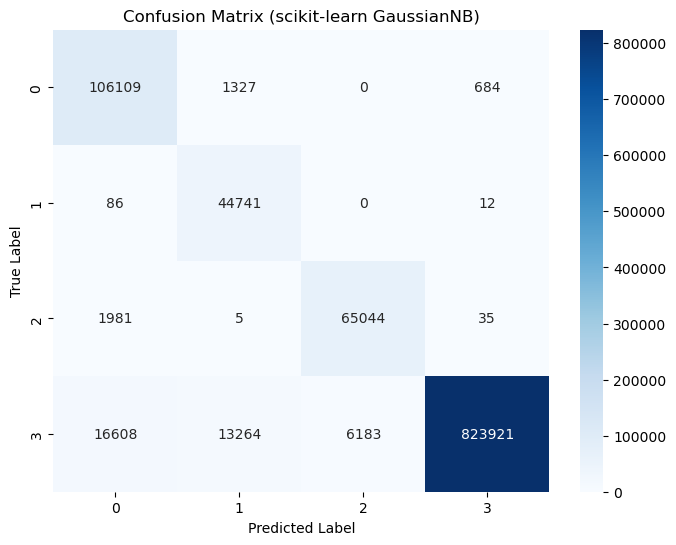

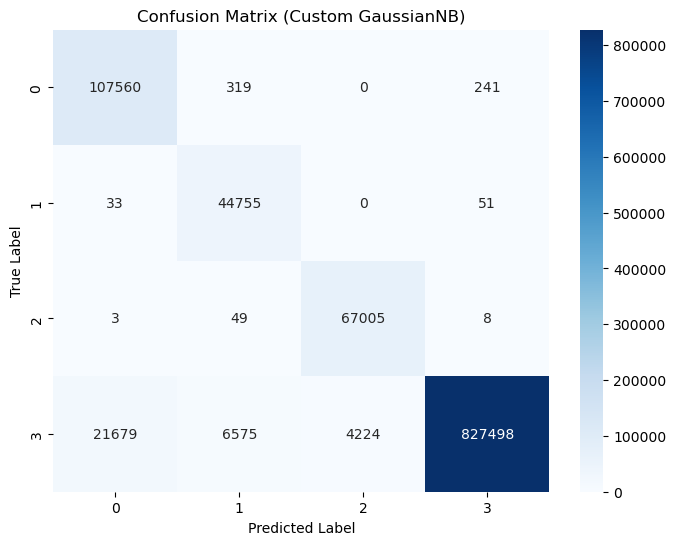

In [11]:
acc_sklearn = accuracy_score(y_true_all, y_pred_sklearn_all)
acc_custom = accuracy_score(y_true_all, y_pred_custom_all)

cm_sklearn = confusion_matrix(y_true_all, y_pred_sklearn_all, labels=[0,1,2,3])
cm_custom = confusion_matrix(y_true_all, y_pred_custom_all, labels=[0,1,2,3])

classes = [0, 1, 2, 3]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_sklearn, annot=True, fmt="d", cmap="Blues", 
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix (scikit-learn GaussianNB)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(cm_custom, annot=True, fmt="d", cmap="Blues", 
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix (Custom GaussianNB)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Now last but not least, let's test the classifiers on the melanoma dataset
Let's start by loading the data and applying gaussian smoothing

In [12]:
data_dir = "./melanoma/ISIC_segmentation"
all_image_paths = glob(os.path.join(data_dir, "*.jpg"))
original_image_paths = [p for p in all_image_paths if "_segmentation" not in os.path.basename(p)]

gaussian_kernel_size = (5, 5)
gaussian_sigma = 0

def load_dataset(image_paths, kernel_size, sigma):
    X_pixels = [] 
    y_pixels = [] 
    overlay_images = [] 
    used_paths = []  # helper to track which images were used

    for path in image_paths:
        img = cv2.imread(path)
        img_blur = cv2.GaussianBlur(img, kernel_size, sigma)

        base = os.path.splitext(os.path.basename(path))[0]
        mask_filename = base + "_segmentation.jpg"
        mask_path = os.path.join(data_dir, mask_filename)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        _, mask_bin = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY) # -> detecting B/W img mask
        h, w, _ = img.shape
        X = img_blur.reshape(-1, 3).astype(np.float32)
        y = mask_bin.reshape(-1)
        X_pixels.append(X)
        y_pixels.append(y)
        overlay_images.append(img)
        used_paths.append(path)
    X_all = np.concatenate(X_pixels, axis=0)
    y_all = np.concatenate(y_pixels, axis=0)
    return X_all, y_all, overlay_images, used_paths

X_all, y_all, overlay_images, used_paths = load_dataset(original_image_paths, gaussian_kernel_size, gaussian_sigma)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)


# Now let's train the classifiers again

In [13]:
sklearn_clf = GaussianNB()
sklearn_clf.fit(X_train, y_train)

custom_clf = MyGaussianNB()
custom_clf.fit(X_train, y_train)

#### This seems to have worked, good. Now we need to eval our classifiers. 
First le's check the accuracies as well as the confusion matrix

Test Accuracy (scikit-learn GaussianNB): 0.952212962962963
Test Accuracy (Custom GaussianNB): 0.9729398148148148
Confusion Matrix (scikit-learn):
 [[161699   3214]
 [  7108  43979]]
Confusion Matrix (custom):
 [[162870   2043]
 [  3802  47285]]


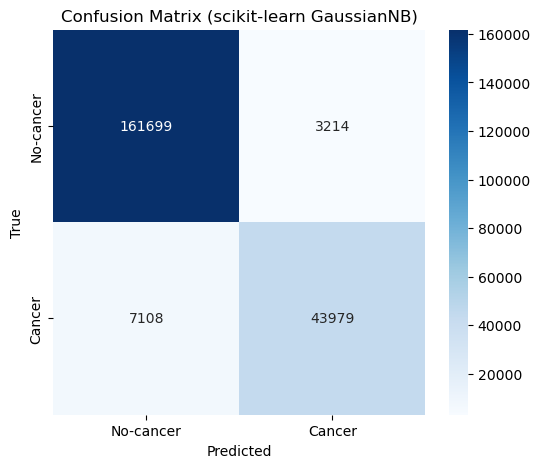

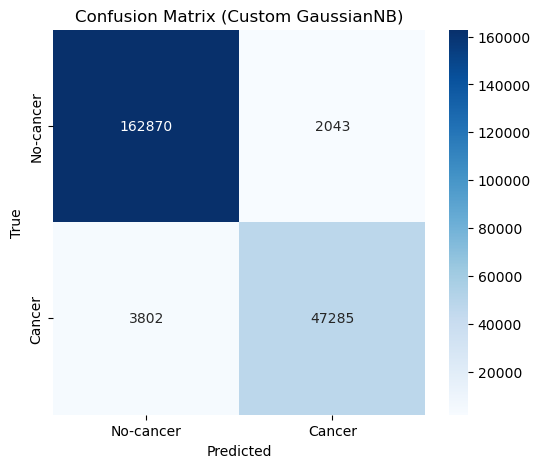

In [14]:
y_pred_sklearn = sklearn_clf.predict(X_test)
y_pred_custom = custom_clf.predict(X_test)

acc_sklearn = accuracy_score(y_test, y_pred_sklearn)
acc_custom = accuracy_score(y_test, y_pred_custom)
print("Test Accuracy (scikit-learn GaussianNB):", acc_sklearn)
print("Test Accuracy (Custom GaussianNB):", acc_custom)

cm_sklearn = confusion_matrix(y_test, y_pred_sklearn, labels=[0,1])
cm_custom = confusion_matrix(y_test, y_pred_custom, labels=[0,1])
print("Confusion Matrix (scikit-learn):\n", cm_sklearn)
print("Confusion Matrix (custom):\n", cm_custom)


plt.figure(figsize=(6,5))
sns.heatmap(cm_sklearn, annot=True, fmt="d", cmap="Blues", xticklabels=["No-cancer", "Cancer"], yticklabels=["No-cancer", "Cancer"])
plt.title("Confusion Matrix (scikit-learn GaussianNB)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

plt.figure(figsize=(6,5))
sns.heatmap(cm_custom, annot=True, fmt="d", cmap="Blues", xticklabels=["No-cancer", "Cancer"], yticklabels=["No-cancer", "Cancer"])
plt.title("Confusion Matrix (Custom GaussianNB)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


#### Okay, this looks good.... with some caviats....Let's plot the ROC

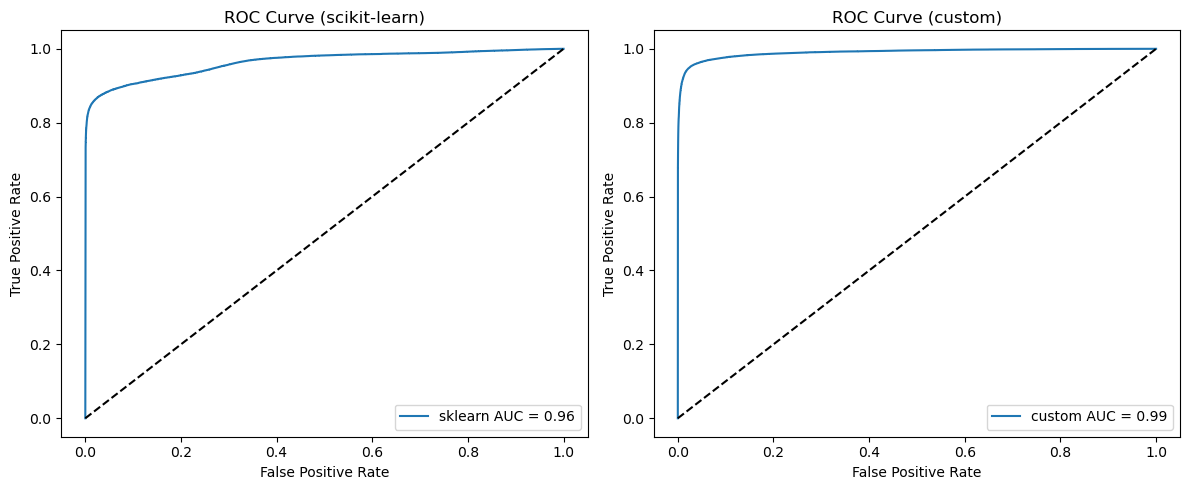

In [15]:
y_test_bin = label_binarize(y_test, classes=[0,1]).ravel()

y_prob_sklearn = sklearn_clf.predict_proba(X_test)[:, 1]
y_prob_custom = custom_clf.predict_proba(X_test)[:, 1]

fpr_sklearn, tpr_sklearn, _ = roc_curve(y_test_bin, y_prob_sklearn)
roc_auc_sklearn = auc(fpr_sklearn, tpr_sklearn)

fpr_custom, tpr_custom, _ = roc_curve(y_test_bin, y_prob_custom)
roc_auc_custom = auc(fpr_custom, tpr_custom)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr_sklearn, tpr_sklearn, label=f"sklearn AUC = {roc_auc_sklearn:.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (scikit-learn)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(fpr_custom, tpr_custom, label=f"custom AUC = {roc_auc_custom:.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (custom)")
plt.legend()
plt.tight_layout()
plt.show()


#### Let's see the results in an overlay

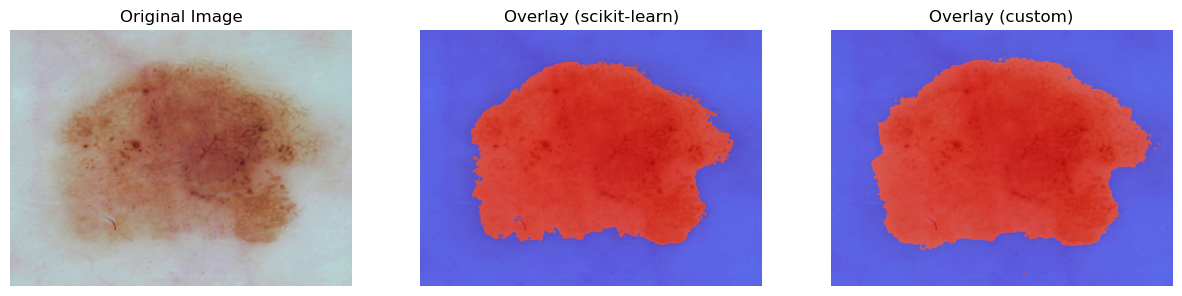

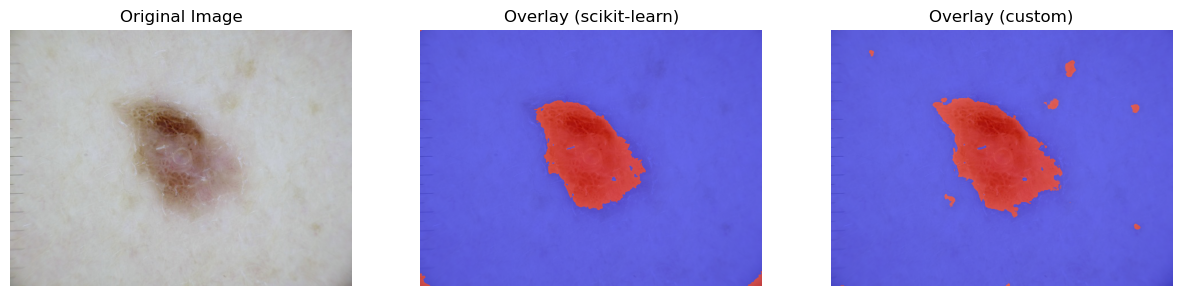

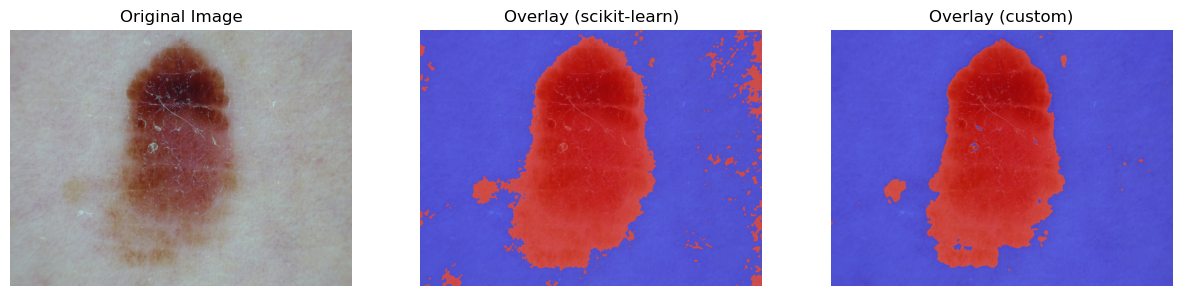

In [16]:
def predict_overlay(image_path, clf, kernel_size, sigma):
    img = cv2.imread(image_path)
    if img is None:
        return None, None
    img_blur = cv2.GaussianBlur(img, kernel_size, sigma)
    h, w, _ = img.shape
    X = img_blur.reshape(-1, 3).astype(np.float32)
    preds = clf.predict(X)
    mask = preds.reshape(h, w)


    seg = np.zeros_like(img)
    seg[mask==0] = (255, 0, 0)   # blue == no-cancer
    seg[mask==1] = (0, 0, 255)   # red == cancer
    overlay = cv2.addWeighted(img, 0.5, seg, 0.5, 0)
    return seg, overlay


for path in used_paths[:3]:
    seg_sklearn, overlay_sklearn = predict_overlay(path, sklearn_clf, gaussian_kernel_size, gaussian_sigma)
    seg_custom, overlay_custom = predict_overlay(path, custom_clf, gaussian_kernel_size, gaussian_sigma)
    img = cv2.imread(path)
    plt.figure(figsize=(15,5))


    plt.subplot(1,3,1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(cv2.cvtColor(overlay_sklearn, cv2.COLOR_BGR2RGB))
    plt.title("Overlay (scikit-learn)")
    plt.axis("off")
    plt.subplot(1,3,3)

    plt.imshow(cv2.cvtColor(overlay_custom, cv2.COLOR_BGR2RGB))
    plt.title("Overlay (custom)")
    plt.axis("off")
    plt.show()

